# RL coursework, part I (20 pts total)
---

**SN:** 15056601

---

**Due date:** *22nd March, 2022,*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):
    def __init__(self, name, number_of_arms, bonus_multiplier):
        self._number_of_arms = number_of_arms
        self._bonus_multiplier = bonus_multiplier
        self.name = name
        self.reset()

    def step(self, previous_action, reward):
        action = 0
        # Check if current steps in time is under the total
        if self.steps < self._number_of_arms:
            # Check we are not in the first attempt
            if self.steps > 0:
                # Update the action counter
                self.action_count[previous_action] = 1
                # Update the values
                self.values[previous_action] = reward
            # Increment step and define the new action
            self.steps += 1
            action = self.steps - 1
            
        else:
            self.steps += 1
            # Update action count
            self.action_count[previous_action] += 1
            # Update the values
            self.values[previous_action] += (1/self.action_count[previous_action])*(reward-self.values[previous_action])
            # Calculate the upper bound, multiplying by the 'c' value (bonus_multiplier)
            ub = [v + self._bonus_multiplier*np.sqrt(np.log(self.steps)/(s)) for v, s in zip(self.values, self.action_count)]
            # Find the maximal upper bound
            action = ub.index(max(ub))
        return action

    def reset(self):
        # Set all statisticis to zero for new agent
        self.action_count  = np.zeros(self._number_of_arms)
        self.values = np.zeros(self._number_of_arms)
        self.steps = 0
    
    

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
    """An epsilon-greedy agent.

    This agent returns an action between 0 and 'number_of_arms'; with probability
    `(1-epsilon)` it chooses the action with the highest estimated value, while
    with probability `epsilon` it samples an action uniformly at random.
    """

    def __init__(self, name, number_of_arms, epsilon=0.1):
        self.name = name
        self._number_of_arms = number_of_arms
        self._epsilon = epsilon
        self.reset()

    def step(self, previous_action, reward):
        """Update the learnt statistics and return an action.

        A single call to step uses the provided reward to update the value of the
        taken action (which is also provided as an input), and returns an action.
        The action is either uniformly random (with probability epsilon), or greedy
        (with probability 1 - epsilon).

        If the input action is None (typically on the first call to step), then no
        statistics are updated, but an action is still returned.
        """
        # Update the value for the previous action
        if previous_action is not None:
            # Update action count
            self.action_count [previous_action] += 1
            # Update the values
            self.values[previous_action] += (1/self.action_count[previous_action])*(reward-self.values[previous_action])
           
        
        # Generate a random probability
        prob = np.random.random()
        
        # Check if epsilon is float or callable
        if isinstance(self._epsilon, float):
            eps = self._epsilon
        else: 
            eps = (self._epsilon)(self.steps)
        
       # If it is lower than epsilon we make a random choice
        if prob < eps:
            # Randomly select an action
            action = np.random.randint(0, high=self._number_of_arms)
        else:
            # Select greedily, we can't use np.argmax(self.values) incase there are multiple and we need to break ties
            action = np.random.choice(np.where(self.values == self.values.max())[0])
            
        self.steps += 1
        return action

    def reset(self):
        # Set all statisticis to zero for new agent
        self.action_count  = np.zeros(self._number_of_arms)
        self.values = np.zeros(self._number_of_arms)
        self.steps = 1

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):
    def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
        self.name = name
        self._number_of_arms = number_of_arms
        self._step_size = step_size
        self._baseline = baseline
        self.reset()

    def step(self, previous_action, reward):
        # Update the baseline if using:
        if reward != None and self._baseline is True:
          # Update the baseline average reward
          self.G += self._step_size * (reward - self.G)

        # Update parameters
        if previous_action is not None:
            # Indicator function for selected actions, with 0's elsewhere
            indicator_arr = np.zeros(self._number_of_arms)
            indicator_arr[previous_action] = 1
            # Update for action preferences
            self.prob += self._step_size * (reward - self.G) * ((indicator_arr / self.prob[previous_action]) - (self.prob / np.sum(self.prob ** 2)))

        # Update policy
        self.policy = (self.prob ** 2) / (np.sum(self.prob ** 2))

        # Select action using random choice based on policy
        action = np.random.choice(self._number_of_arms, p=self.policy)

        # Increment time step
        self.steps += 1

        return action

    def reset(self):
        # Set all statisticis to zero for new agent
        self.prob = np.ones(self._number_of_arms)
        self.policy = [1/self._number_of_arms]*self._number_of_arms
        self.G = 0
        self.steps = 0
        

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

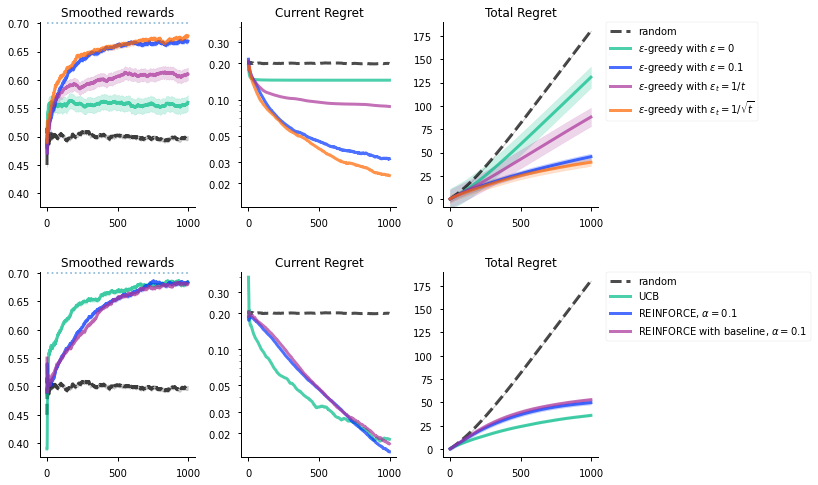

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

Our aim is to minimise total regret and maximise cumulative reward. Each algorithm preformed differently in terms of total regret. Below is an explanation for each algorithm explaining whether we expect it to be good in general:

1. Epsilon-Greedy ($\epsilon = 0$):<br> 
>This results in a Greedy algorithm, which can get stuck on a suboptimal action forever, implying a linear expected total regret. As it can be seen from the graph, we have no exploration phase and therefore, we do not expect it to be good in general hence, the results we got are in line with our expectation.


2. Epsilon-Greedy ($\epsilon = 0.1$) :<br> 
>This is an improvement from the Greedy algorithm. As it can be seen from the graph the total regret over time is considerably smaller than that of the Greedy Algorithm. We have a high exploration probability and therefore, we do not expect it to get stuck in suboptimal actions, the results we got are in line with our expectation and we expect it to outpreform plain Greedy in the general case.


3. Epsilon-Greedy ($\epsilon = 1/t$):<br> 
>This is similar to the above Epsilon-Greedy (0.1) algorithm however, epsilon decreases over time at a relatively fast rate therefore, the exploration probability decreases and we are more likley to get stuck on a suboptimal action, since epsilon converges to zero, and then ultimately the algorithm will behave like the plain Greedy algorithm over time. This algorithm isn't expected to preform as well as the Epsilon-Greedy (0.1) algorithm.  


4. Epsilon-Greedy ($\epsilon = 1/sqrt(t)$):<br> 
>This last algorithm is the most optimal of the Epsilon-Greedy family. Epsilon decreases over time at a very slow rate therefore, we are able to explore with high probability for a while. This gives the algorithm enough time to learn about the optimal actions via exploration. This algorithm is expected to be good in general.


5. UCB:<br> 
>This algorithm ensures that we always keep exploring, but not too much. Due to the optimal action being identified quickly, and only trying the other actions when they have high uncertainty, the UCB method shows a much lower level of regret than seen in the Epsilon-Greedy method. This algorithm is expected to work well.


6. Random:<br> 
> This algorithm has maximum probability of exploring. The algorithm does not learn anything from the data. Therefore, as it can be seen from the above graph, the total regret is expected to grow linearly over time. This algorithm is not expected to work well.


7. REINFORCE, $\alpha = 0.1$ <br> 
> This algorithm uses a model that takes a state as input and generates the probability (in our case the square-max) of taking an action as output. This algorithm preformed better in terms of total regret in comparison to the previous algorithms. We expect it to work well.


8. REINFORCE, baseline $\alpha = 0.1$ <br> 
> This algorithm is similar to the REINFORCE above, however with the addition of baseline, the learned state-value function estimates the value of the only the first state of each state transition. This estimate sets a baseline for the subsequent return, but is made prior to the transition's action and thus cannot be used to assess that action. Therefore, we improve the basic REINFORCE algorithm by simply reducing the variance. This algorithm is expected to preform as well if not better than basic REINFORCE.


**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

> The most optimal algorithm in the $\epsilon$-greedy family was $\epsilon = 1/sqrt(t)$. In this algorithm epsilon decreases over time at a slow rate and therefore, the agent is able to explore with high probability for a while. This gives the agent enough time to learn about the optimal actions via exploration. $$$$Closely following is $\epsilon = 0.1$ which has proven to be the second optimal algorithm. The exploration probability is relatively high at 10% hence, we don't expect the agent to get stuck in suboptimal actions.$$$$ $\epsilon = 1/t$ does not preform as well as the previous two algorithms. Epsilon decays over time at a relatively fast rate and thus converges to epsilon of zero. After 50 steps, $\epsilon = 0.02$ which is very small, and therefore, it comes at no suprise that it behaves similarly to greedy algorithm. $$$$Lastly, $\epsilon = 0$, also known as the Greedy algorithm. There is no room for exploration and this means that the first action that gives a non-zero reward will be selected continuously from that point. It is important to note that there is a small probability that the initially selected action could be the optimal action, but this is unlikely and becomes less likely as the number of actions increases. Therefore, we do not expect it to be good in general hence, the results we got are in line with our expectation. 

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

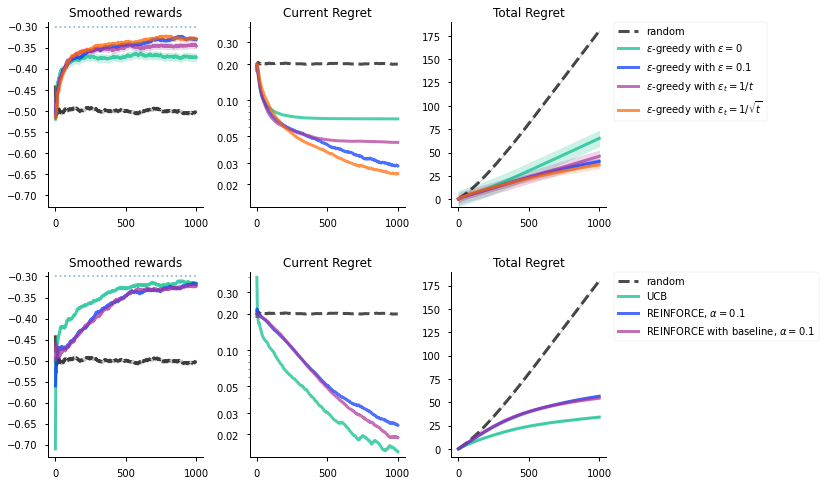

In [12]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

1. Epsilon-Greedy ($\epsilon = 0$):<br> 
> This algorithm has clearly improved the most from the change in reward. This change means that all actions should be explored initially, with the algorithm continuing to choose the most rewarding of the explored actions, and then as a Greedy algoroithm does continue selecting the most optimal selection.


2. Epsilon-Greedy ($\epsilon = 0.1$) :<br> 
> This algorithm has continued to perform well with very little signs of improvement. 


3. Epsilon-Greedy ($\epsilon = 1/t$):<br> 
> This algorithm has very slightly improved, but less than the improvements witnessed for  $\epsilon = 0$, as this approach already encourages early exploration.

4. Epsilon-Greedy ($\epsilon = 1/sqrt(t)$):<br> 
> Similarly, this algorithm continues to perform well for similar reasons as mentioned in $\epsilon = 0.1$.


5. UCB:<br> 
> This approach has again preformed the best and has shown slight improvements. UCB has always encouraged exploration of all actions at the start and therefore this configuration has not caused UCB to behave very differently. 


6. Random:<br> 
> There is no signs of improvement for this algorithm. This makes sense as this algorithm does not learn anything from the data and therefore a change in the rewards will not affect the actions selected.

7. REINFORCE, $\alpha = 0.1$ <br> 
> This algorithm does not look like it improves by much.  

8. REINFORCE, $\alpha = 0.1$ <br> 
> Similarly, the addition of baseline looks like it improves the model by a fraction. 


## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

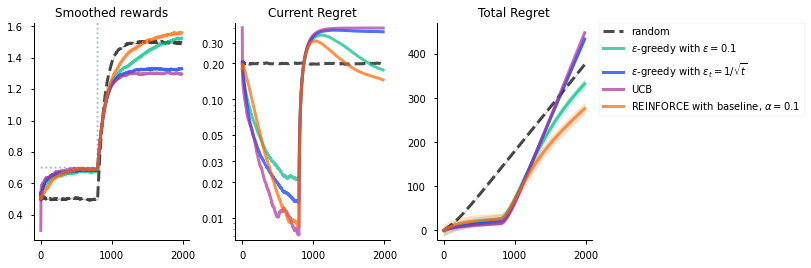

In [15]:
experiment3.show()

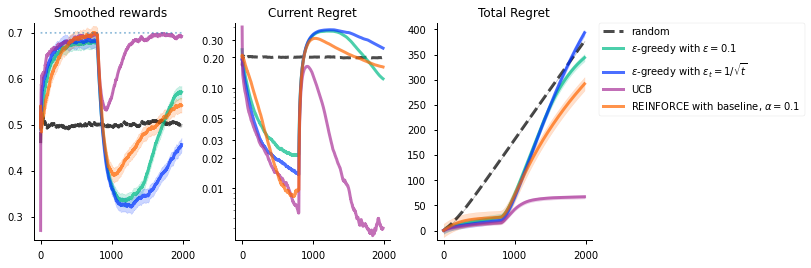

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> This section shows very interesting results. The general trend for all algorithms is a decrease in current regret and after the 800th step, a sharp increase to which the algorithms each adjust to the change in reward. 
The best algorithms for dealing with this configuration are REINFORCE with baseline and $\epsilon = 0.1$ greedy. It seems that both these algorithm continue to select low reward actions, using probability or exploration, later in training. This means that they adapt even at later stages of training and therefore are able to select the new high reward actions. 
The two worst algorithms are $\epsilon =1/sqrt(t)$ greedy and UCB, as they clearly do not adapt well to the change. They both continue to select the non-optimal actions. In the $\epsilon =1/sqrt(t)$ greedy algorithm, at step 800 epsilon has decayed far enough to ~$0.035$ and thus the algorithm is no longer exploring as frequently and gets stuck selecting the suboptimal actions. Given the actions have already been selected a large number of times UCB will be narrow, with the reward remaining constant for selecting the previously rewarded actions.


**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> This section yields very different results to experiment 3. In this configuration UCB performs much better, quickling adapating to the change in rewards. $\epsilon = 0.1$ greedy also preformed well as it will continue to explore lower predicted reward actions and update to the new rewards. Interestingly, REINFORCE with baseline doesn't improve as quickly as UCB or $\epsilon = 0.1$ greedy. This can be due to the fact that the running average is slow to update however, we can expect it to eventually reach similar results to UCB and $\epsilon = 0.1$ greedy. $\epsilon =1/sqrt(t)$ greedy has improved in this configuration, this can be due to the fact that the Q values decrease for the previous rewarding actions that at this stage have been highly exploited. This causes a switch and the agent begins to select and exploit new actions, which are ultimately more rewarding. 


**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> In experiment 3, we can see that UCB has no intention of selecting the previous failure actions. This is due to the funtementals of how the UCB algorithm is defined. It has built up a high confidence in the predicted rewards and in experiment 3 it is not penalised for sleecting them, therefore there is no reason for an adjustment. It can take a lot of iterations for UCB to select previously seen low rewarded actions and therefore it will take time for UCB to adjust to the optimal action rew3ard selection.
In experiment 4 however, as UCB keeps selecting the high confidence actions, the expected rewards for UCB decreases and therefore the switch to selecting previous failure actions (which are now higher rewarded) will come at a much quicker pace.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> We can modify UCB to perform better, by introducing a discounting factor. We can give more importance (give more weight) to actions taken recently and thus, improve our performance. This addition allows the agent to give more importance to more recent actions and forgets the actions taken in the far past. This is particularly helpful when considering experiemnts such as 3 and 4. 

